<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Workshop optimización de portfolio con algoritmos genéticos

<img src="https://m.media-amazon.com/images/I/41QDhBABUGL.jpg" width="200"></img>

En este caso realizaremos un otimizador de portfolios de inversion en mercados inmobiliarios usando algoritmos genéticos


**Notebook por: David Rey**

In [ ]:
#
# Carga de librerías
#
import sys
if 'deap' not in sys.modules:
  !pip install deap
import array
import random
import numpy
import math
import deap as deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt



     |████████████████████████████████| 163kB 14.3MB/s 


# Descripción del conjunto de datos

Nuestros datos contienen información del mercado de la vivienda de todos los barrios de Madrid. Principalmente el precio medio, la rentabilidad histórica y los niveles de impago de cada zona.

In [ ]:
#
# Cargamos los datos
#
url = 'https://github.com/davidreyblanco/ml-training/raw/master/data/investment/market-footprint.csv.gz'
locations = pd.read_csv(url, delimiter=';')
locations.head(5)

,LOCID,LOCATIONNAME,STOCK_SALE,STOCK_RENT,N_DWELLING,N_PARCEL,RENTSALE_RATIO,EFFORT_RATE,DELINQUENCY_RATE,TXN_DISCOUNT,TOM,GROSS_YIELD,RENT_PRICE,SALE_PRICE
0,280700107914004,Media Legua,169,72,294,331,0.426036,0.194491,0.075,0.039028,62,0.067261,9768,275355
1,280700107912007,Pradolongo,263,80,959,1039,0.304183,0.194174,0.090,0.081055,65,0.065316,2222,146013
2,280700107918002,Santa Eugenia,181,37,157,203,0.204420,0.185066,0.086,0.031467,49,0.092674,2072,194009
3,280700107902005,Delicias,731,496,377,440,0.678523,0.251585,0.053,0.070456,55,0.043321,1539,302878
4,280700107904006,Castellana,890,1587,438,554,1.783146,0.303436,0.028,0.086658,110,0.073110,3697,1080287


El listado de los campos es

In [ ]:
locations.columns

Index(['LOCID', 'LOCATIONNAME', 'STOCK_SALE', 'STOCK_RENT', 'N_DWELLING',
       'N_PARCEL', 'RENTSALE_RATIO', 'EFFORT_RATE', 'DELINQUENCY_RATE',
       'TXN_DISCOUNT', 'TOM', 'GROSS_YIELD', 'RENT_PRICE', 'SALE_PRICE'],
      dtype='object')

El significado de los campos es:
* **LOCID** Codigo interno de la localización
* **LOCATIONNAME** Codigo interno de la localización
* **STOCK_SALE**  número de inmuebles de tipo residencial en mercado (en compraventa).
* **STOCK_RENT** número de inmuebles de tipo residencial en mercado (en alquiler).
* **N_DWELLING**  numero de inmuebles de tipo residencial en una zona (registradas en catastro).
* **N_PARCEL** numero de fincas de tipo residencial en una zona (registradas en catastro).
* **RENTSALE_RATIO** ratio de inmuebles en alquiler / inmuebles en venta en una zona.
* **EFFORT_RATE** % de ingresos que dedica una persona a vivienda dentro de sus ingresos mensuales.
* **DELINQUENCY_RATE** tasa de impago de los inmuebles en alquiler en una zona. Representa la probabilidad de que una cuota de alquiler se impague si alquilamos en una zona.
* **TXN_DISCOUNT** descuento medio necesario para vender el inmueble (% que un propietario descuenta sobre el precio de mercado de un inmueble)
* **TOM** días medios mercado para vender un inmueble en una zona.
* **GROSS_YIELD** rentabilidad bruta anual del alquiler (no tiene en cuenta los gastos por parte del propietario).
* **RENT_PRICE** precio medio de alquiler / mes de un inmueble en la zona.
* **SALE_PRICE** precio medio de venta de un inmueble en la zona.

Generamos unos mínimos descriptivos

In [ ]:
locations.describe()

,LOCID,STOCK_SALE,STOCK_RENT,N_DWELLING,N_PARCEL,RENTSALE_RATIO,EFFORT_RATE,DELINQUENCY_RATE,TXN_DISCOUNT,TOM,GROSS_YIELD,RENT_PRICE,SALE_PRICE
count,1.260000e+02,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,1.260000e+02
mean,2.807001e+14,486.460317,398.277778,843.746032,941.873016,0.704974,0.244460,0.064627,0.075752,77.944444,0.088759,5773.928571,3.581225e+05
std,5.889206e+03,293.141867,443.328423,620.785231,650.921599,0.435869,0.054031,0.022996,0.025206,19.715702,0.032779,3030.753005,2.449582e+05
min,2.807001e+14,130.000000,23.000000,69.000000,120.000000,0.068136,0.098769,0.023000,0.025901,47.000000,0.034229,1022.000000,8.392900e+04
25%,2.807001e+14,263.000000,108.250000,419.500000,468.250000,0.315491,0.194580,0.046000,0.057970,65.000000,0.060268,3475.750000,1.821250e+05
50%,2.807001e+14,447.000000,243.500000,674.000000,774.500000,0.626733,0.252938,0.059500,0.072678,72.000000,0.089839,5180.500000,2.752550e+05
75%,2.807001e+14,623.000000,494.500000,1125.000000,1251.750000,0.958476,0.286096,0.083750,0.093188,88.250000,0.118642,8111.000000,4.714268e+05
max,2.807001e+14,1799.000000,2341.000000,3540.000000,3732.000000,1.812207,0.350512,0.130000,0.159382,141.000000,0.160618,12111.000000,1.230796e+06


# Ejercicio 1 - Selector de las mejores zonas

Nuestro objetivo es construir una selección de zonas con un **genotipo binario** que cumplan nuestros requisitos de inversion:

* La rentabilidad esperada media estará por encima del 5%
* La tasa de morosidad media de las zonas elegidas debe estar por debajo de 12%

Nuestra función de fitness buscará la mayor rentabilidad pero coontrolando el riesgo y en un número de zonas limitado:

* Nuestra función de fitness combinará la rentabilidad y la seguridad en el pago (inverso de la morosidad)
* Favorecerá el caso de tener menos zonas en las que invertir versus las opciones con muchas zonas recomendadas

El resultado será una lista con las zonas en las que vamos a invertir




In [ ]:
#
# Ejemplo completo (corta)
#
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generador de atributosructura
toolbox.register("attr_bool", random.randint, 0, 1)

# Inicializadores de la estructura
# Inviduo como 100 atributos booleanos y población como una repetición de individuos
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(locations))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Declaramos una serie de operadores (algunos de ellos a partir de los ya disponibles en tools)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Definición de la función de fitness

In [ ]:
# Definimos nuestra función de objetivo / fitness
def fitness_portfolio(individual):
    n_items = sum(individual)
    selection_bool = list(map(lambda x: x==1, individual.tolist()))
    if (numpy.average(locations[selection_bool]['GROSS_YIELD']) < 0.05):
      fitness = 0
    elif (numpy.average(locations[selection_bool]['DELINQUENCY_RATE']) > 0.12):
      fitness = 0
    else:
      fitness = numpy.average(numpy.average(locations[selection_bool]['GROSS_YIELD']) * (1 - locations[selection_bool]['DELINQUENCY_RATE']))
    fitness = fitness * (0.98**(n_items - 1))
    # Penalty by number of zones
    return fitness,

toolbox.register("evaluate", fitness_portfolio)

Declaramos el algoritmo genético:

In [ ]:
# Declaramos una función
def genetic_algorithm(npop=300,
                      ngen=20,
                      cxpb=0.5,
                      mutpb=0.05,
                      toolbox = toolbox):
    random.seed(64)

    pop = toolbox.population(n=npop)
    # Usamos esta utilidad
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop,
                                   toolbox,
                                   cxpb=cxpb,
                                   mutpb=mutpb,
                                   ngen=ngen,
                                   stats=stats,
                                   halloffame=hof,
                                   verbose=False)

    return pop, log, hof

#
# Declaramos una función para mostrar los gráficos de convergencia
#
def plot_convergence_chart(log):
  df = pd.DataFrame(log)
  plt.plot(df['gen'], df['avg'])
  plt.title('Convergencia modelo de optimización')
  plt.xlabel('Generación')
  plt.ylabel('Fitness medio')
  plt.show()
  return df

Ejecución del optimizador

In [ ]:
#
# Ejecución optimizador
#
pop, logbook, hof = genetic_algorithm(npop=100,
                                      ngen=200,
                                      cxpb=0.3,
                                      mutpb=0.1,
                                      toolbox=toolbox)

In [ ]:
#
# Mostramos los resultados de nuestra selección
#
print(hof)
selection = hof[0].tolist()
selection_bool = list(map(lambda x: x==1, selection))
dr = numpy.average(locations.iloc[selection_bool]['DELINQUENCY_RATE'])
gy = numpy.average(locations.iloc[selection_bool]['GROSS_YIELD'])
ds = numpy.average(locations.iloc[selection_bool]['TXN_DISCOUNT'])
print('-------------------------------')
print(' Seleccion zonas portfolio ')
print('-------------------------------')
print('Tasa de morosidad: ' + str(round(100*dr,2))+' %')
print('Rentabilidad (gross yield): ' + str(round(100*gy,2))+' %')
print('Descuento medio (average txn_discount): ' + str(round(100*ds,2))+' %')
print('Número de zonas seleccionadas: ' + str(sum(selection)))
print()
print('-------------------------------')
print(' Población general ')
print('-------------------------------')

print('Tasa de morosidad: ' + str(round(100*numpy.average(locations['DELINQUENCY_RATE']),2))+' %')
print('Rentabilidad (gross yield): ' + str(round(100*numpy.average(locations['GROSS_YIELD']),2))+' %')
print('Descuento medio (average txn_discount): ' + str(round(100*numpy.average(locations['TXN_DISCOUNT']),2))+' %')
print('Número de zonas seleccionadas: ' + str(len(locations)))

[Individual('b', [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
-------------------------------
 Seleccion zonas portfolio 
-------------------------------
Tasa de morosidad: 8.09 %
Rentabilidad (gross yield): 12.91 %
Descuento medio (average txn_discount): 8.73 %
Número de zonas seleccionadas: 10

-------------------------------
 Población general 
-------------------------------
Tasa de morosidad: 6.46 %
Rentabilidad (gross yield): 8.88 %
Descuento medio (average txn_discount): 7.58 %
Número de zonas seleccionadas: 126


Dibujamos el gráfico de convergencia

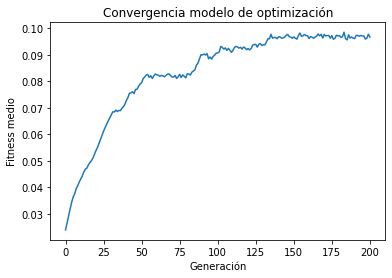

In [ ]:
df = plot_convergence_chart(logbook)

Mostramos en número la evolución del proceso

In [ ]:
df

,gen,nevals,avg,std,min,max
0,0,100,0.023986,0.003261,0.017391,0.032321
1,1,36,0.026642,0.002668,0.020668,0.035703
2,2,39,0.029227,0.002823,0.024519,0.039207
3,3,34,0.031846,0.003165,0.025723,0.040832
4,4,35,0.034344,0.002814,0.028061,0.040878
...,...,...,...,...,...,...
196,196,24,0.097068,0.006468,0.070319,0.098926
197,197,43,0.095922,0.007822,0.063558,0.098926
198,198,40,0.096288,0.007571,0.066776,0.098926
199,199,33,0.097741,0.004884,0.072003,0.098926


In [ ]:
#
# Mostramos que zonas zonas ordenadas por rentabilidad
#
selected_areas = locations.iloc[selection_bool]
selected_areas[['LOCATIONNAME','DELINQUENCY_RATE','GROSS_YIELD','TXN_DISCOUNT','SALE_PRICE','RENT_PRICE']].sort_values(by=['GROSS_YIELD'],
                                                                                                                       ascending=False)

,LOCATIONNAME,DELINQUENCY_RATE,GROSS_YIELD,TXN_DISCOUNT,SALE_PRICE,RENT_PRICE
13,Entrevías,0.118,0.160618,0.060228,118550,2564
66,Campamento,0.083,0.154847,0.093042,152404,7253
73,Casco Histórico de Vicálvaro,0.091,0.149531,0.075911,156572,9526
103,San Cristóbal,0.130,0.147458,0.079251,83929,10280
108,Pinar del Rey,0.066,0.138820,0.045282,244089,5177
16,Conde Orgaz-Piovera,0.043,0.123780,0.093386,852946,3470
40,Moscardó,0.081,0.123515,0.072059,149827,3170
7,Chueca-Justicia,0.037,0.105786,0.136794,631955,10300
64,Ventilla-Almenara,0.058,0.098062,0.124244,268336,3922
19,Zofío,0.102,0.088538,0.093236,134697,5088


# Ejercicio 2 - ¿Cúanto invertimos?


Ahora vamos a hacer el ejercicio con el total de la inversión sobre las zonas seleccionadas. Para ello usaremos la métrica **Yield**:

$$
Yield_{i} = \frac{Gross\ Yield_{i}}{1 - txn\ discount_{i}}
$$

Para cada zona podemos estimar los ingresos del alquiler anual. Nuestra función de fitness será los ingresos mensuales que podemos conseguir para una inversión determinada

$$
Ingresos = \sum_{zona = i}^{N}(Sale\ Price_i \cdot Yield_i) \cdot (1 - Delinquency\ rate_i)
$$


Usaremos enteros, revisar:

¿Qué **tipo** debemos usar?
https://docs.python.org/3/library/array.html

Y sobre los **operadores**, ¿cuáles usaremos?
https://deap.readthedocs.io/en/master/api/tools.html

In [ ]:
def intBlend(a, b, cxpb=0.8):
  a = a.copy()
  b = b.copy()
  if random.random() < cxpb:
    a_new = creator.Individual(numpy.array(list((a + b) / 2)))
    a = a_new
    b = a_new
  return a, b

In [ ]:
#
# Generamos todos los elementos
#
creator.create("FitnessPortfolio", base.Fitness, weights=(1.0,))
creator.create("Individual", numpy.ndarray, typecode='i', fitness=creator.FitnessPortfolio)

toolbox = base.Toolbox()

# Generador de atributos, vamos a restringir los valores de la entrada al rango de nuestra muestra
toolbox.register("attr_int", random.randint, 0, 50)

# Inicializadores de la estructura
# Inviduo como 100 atributos booleanos y población como una repetición de individuos
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, len(selected_areas) )
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Declaramos una serie de operadores (algunos de ellos a partir de los ya disponibles en tools)
toolbox.register("mate", intBlend, cxpb=0.8)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(selected_areas), indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Definición del algoritmo

In [ ]:
# Declaramos una función
def genetic_algorithm_portfolio(npop=300,
                      ngen=20,
                      cxpb=0.5,
                      mutpb=0.05,
                      toolbox = toolbox):
    random.seed(64)

    pop = toolbox.population(n=npop)
    # Usamos esta utilidad
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    pop, log = algorithms.eaSimple(pop,
                                   toolbox,
                                   cxpb=cxpb,
                                   mutpb=mutpb,
                                   ngen=ngen,
                                   stats=stats,
                                   halloffame=hof,
                                   verbose=False)

    return pop, log, hof


Para cada zona podemos estimar los ingresos del alquiler anual. Nuestra función de fitness será los ingresos mensuales que podemos conseguir para una inversión determinada

$$
Ingresos = \sum_{zona = i}^{N}(Sale\ Price_i \cdot \frac{Gross\ Yield_{i}}{1 - txn\ discount_{i}}) \cdot (1 - Delinquency\ rate_i)
$$

In [ ]:
adjusted_yield = selected_areas['GROSS_YIELD'] / (1 - selected_areas['TXN_DISCOUNT'])
non_delinquency_rate = (1- selected_areas['DELINQUENCY_RATE'])
factor = adjusted_yield * non_delinquency_rate
MAX_BUDGET = 1e8

# Definimos nuestra función de objetivo / fitness
def fitness_portfolio_total(individual):
    total_sale_price = selected_areas['SALE_PRICE'] * list(individual)
    fitness = round(sum(total_sale_price * factor))
    return fitness,

# Definimos nuestra función de objetivo / fitness
def fitness_portfolio_metrics(individual):
    total_sale_price = selected_areas['SALE_PRICE'] * list(individual)
    fitness = round(sum(total_sale_price * factor))

    return fitness, sum(total_sale_price)

toolbox.register("evaluate", fitness_portfolio_total)

In [ ]:
pop, logbook, hof = genetic_algorithm_portfolio(npop=100,
                                      ngen=120,
                                      cxpb=0.9,
                                      mutpb=0.05,
                                      toolbox=toolbox)

ValueError: ignored

In [ ]:
total_sale_price = locations['SALE_PRICE'] * list(hof[0])

In [ ]:
individual = toolbox.population(n=1)[0]
total_sale_price = locations['SALE_PRICE'] * list(individual)
print(total_sale_price.head(2) / 1e6)
print(max(total_sale_price)  / 1e6)

print(locations['SALE_PRICE'].head(2))
print(individual[0:2])
print(sum(total_sale_price) / 1e6)

0    3.579589
1    1.022091
Name: SALE_PRICE, dtype: float64
11.59974
0    275353
1    146013
Name: SALE_PRICE, dtype: int64
[13  7]
287.024445


In [ ]:
individual = hof[0]
print(individual)
print(fitness_portfolio_total(individual))
print(fitness_portfolio_metrics(individual))

[ 7  1 10  9  6  8 10  0  3  4 11 12 10 12 12  3 11 13 12 10  2  1 13  6
  7  3 11  0  1  6 10  0  1  2  1  9  0  9  4  3  8  3  1 13  0 12  7  6
  3  4 11  2  8  6  5  8  4 11  5 11  7  8  2  0  0  3  7  2  3  3  0 10
  4  3 10  3 13 12  0 11 12  4 13 13  1  2  4  3 10 13  9 10  3 13 10  3
  2  9  4  6  7  4 11  5  2  4  2 13  2  4  0  2  0  1  1  8  0 13  2  5
  8  4 13  6 12  7]
(11168558,)
(11168558, 279575271)


In [ ]:
z = fitness_portfolio_metrics(hof[0])
print(sum(hof[0]))
print(z[0])
print(z[1]/1e8)
print(z[0] / z[1])

762
11168558
2.79575271
0.03994830429762867


In [ ]:
print(hof[0])
print(fitness_portfolio_total(hof[0]))

[ 60  15  80  78  51  68 117  87   2  26 126  34  90 116 102  80 102  97
  25  89 104  99  83 124  18  10 110  53  56  25  92   3  10  51  86 116
   0 118   8  22  13  75   5 121  75  33  28  69  25  11 104   3  98  58
  50 114  27  37  95  17  70  54  45  65  39  95  46  88  62  66  22   6
   0  29  59  20  27  28   7  82  35  27  86  31 106 101   3  92 103 120
  38 111 109  14 113  20  38  28  82 111  72  86  30 116 123 111  83  31
 121 122  19  78  33  54 117  56  38  90  47  21  35  19 105  22  38   5]
(0,)


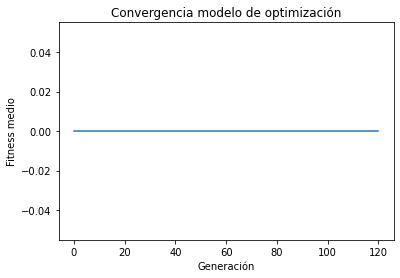

In [ ]:
plot_convergence_chart(logbook)